## Data: [User Data](https://www.kaggle.com/chinapage/china-mobile-user-gemographics) and [Phone Data](https://www.gsmarena.com/)

<b>Through the analysis of the phone user’s features (information regarding age group, location, app usage, or gender) is it possible to determine the user’s phone manufacturer? In addition through the knowledge of the user’s phone features and app usage, can I determine extrapolate some of the user’s details? In addition to these two questions, can we use the data to map out any correlations that may help a business make a more informed decision on advertising?</b>

In [1]:
# Import the necessary modules
import requests
import glob
from collections import defaultdict
import numpy as np
import pandas as pd
import datetime
import json
import re
from pandas.io.json import json_normalize
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

In [2]:
# Open and observe the phone data
phone_df = pd.read_csv('data\\phone_dataset.csv', header=0, delimiter=',')
# Dropping the img_url column because we are not analyzing the phone picture
phone_df = phone_df.drop('img_url', axis=1)
# Drop columns with data less than 1000
empty_cols = list(
    filter(lambda col: phone_df[col].notnull().sum() < 1000, phone_df.columns))
phone_df = phone_df.drop(empty_cols, axis=1)
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9301 entries, 0 to 9300
Data columns (total 36 columns):
brand                 9301 non-null object
model                 9301 non-null object
network_technology    9301 non-null object
2G_bands              9301 non-null object
3G_bands              5494 non-null object
4G_bands              2192 non-null object
network_speed         5520 non-null object
GPRS                  9269 non-null object
EDGE                  9278 non-null object
announced             9285 non-null object
status                9301 non-null object
dimentions            9281 non-null object
weight_g              8365 non-null object
weight_oz             8365 non-null object
SIM                   9296 non-null object
display_type          9297 non-null object
display_resolution    8082 non-null object
display_size          9254 non-null object
OS                    5557 non-null object
CPU                   5496 non-null object
Chipset               4320 non-nu

In [3]:
# Read the rest of the csv files and store them
csvfiles = glob.glob('data/*.csv')
csvfiles.remove('data\\phone_dataset.csv')
dfdict = defaultdict(pd.DataFrame)
csvnames = [str(csvname[5:]) for csvname in csvfiles]
# Place them into a dictionary for easy access and readability
for index, file in enumerate(csvfiles):
    df = pd.read_csv(file, index_col=None, header=0, delimiter=',')
    dfdict[csvnames[index]] = df

In [4]:
# A view of all
for dfname, dfdata in dfdict.items():
    print(dfname)
    display(dfdata.head())

app_events.csv


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


app_labels.csv


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


events.csv


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


gender_age_train.csv


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


label_categories.csv


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


phone_brand_device_model.csv


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [5]:
# Roll up the data to be viewed based off the device id (user)
user_detail_df = pd.merge(
    left=dfdict['events.csv'], right=dfdict['gender_age_train.csv'], how='outer', on='device_id')
# Get rid of the zero long/lat values as those make no sense
user_detail_df = user_detail_df.replace({0: np.nan})
# then drop the NaN values
user_detail_df = user_detail_df.dropna(axis=0)
# then we drop the repeated device_ids as repeats simply mean the same person used multiple apps
user_detail_df = user_detail_df.drop_duplicates(
    subset=['device_id'], keep='first').reset_index(drop=True)
# finally we have cleaner data, but the cost of the clean-up is the loss of the majority of the devices
display(user_detail_df.shape)

(11980, 8)

In [6]:
# We do the same with the app events table
user_phone_df = pd.merge(left=dfdict['phone_brand_device_model.csv'],
                         right=dfdict['gender_age_train.csv'], how='outer', on='device_id')
#user_phone_df = user_df.merge(dfdict['phone_brand_device_model.csv'],how='left',on='device_id')
user_phone_df = user_phone_df.dropna(axis=0)
# There seems to be some duplicated data in the phone_brand_device_model
# There are some errors because it shouldn't be possible for a device to have different
user_phone_df = user_phone_df.drop_duplicates(
    subset=['device_id'], keep='first').reset_index(drop=True)
display(user_phone_df.groupby('phone_brand').count()[
        ['device_id']].sort_values(by='device_id', ascending=False)[:10])
# This data has all of the users with their respective devices and I grouped the data up

,device_id
phone_brand,
小米,17299
三星,13669
华为,12960
OPPO,5783
vivo,5637
魅族,4699
酷派,3339
联想,2691
金立,1123


In [7]:
translation_dict = {"三星": "Samsung", "天语": "Ktouch", "海信": "hisense", "联想": "Lenovo",
                    "欧比": "obi", "爱派尔": "ipair", "努比亚": "ZTE", "优米": "youmi", "朵唯": "dowe",
                    "黑米": "heymi", "锤子": "hammer", "酷比魔方": "koobee", "美图": "meitu",
                    "尼比鲁": "nibilu", "一加": "OnePlus", "优购": "yougo", "诺基亚": "Nokia",
                    "糖葫芦": "candy", "中国移动": "China Mobile", "语信": "yuxin", "基伍": "kiwu", "青橙": "greeno",
                    "华硕": "asus", "夏新": "Panasonic", "维图": "weitu", "艾优尼": "aiyouni",
                    "摩托罗拉": "Motorola", "乡米": "xiangmi", "米奇": "micky", "大可乐": "bigcola",
                    "沃普丰": "wpf", "神舟": "hasse", "摩乐": "mole", "飞秒": "fs", "米歌": "mige",
                    "富可视": "fks", "德赛": "desci", "梦米": "mengmi", "乐视": "LeEco", "小杨树": "smallt",
                    "纽曼": "newman", "邦华": "banghua", "E派": "epai", "易派": "epai", "普耐尔": "pner",
                    "欧新": "ouxin", "西米": "ximi", "海尔": "haier", "波导": "bodao", "糯米": "nuomi",
                    "唯米": "weimi", "酷珀": "kupo", "谷歌": "Google", "昂达": "ada", "聆韵": "lingyun",
                    "小米": "Xiaomi", "华为": "Huawei", "魅族": "Meizu", "酷派": "Coolpad", "索尼": "Sony",
                    "金立": "Gionee", "酷比": "koobee", "奇酷": "qiku", "欧博信": "OPSSON", "中兴": "ZTE",
                    "至尊宝": "Best sonny", "百立丰": "lephone", "亿通": "yitong", "康佳": "KONKA",
                    "优语": "lebest", "斐讯": "phicomm", "果米": "GUOMI", "诺亚信": "Noain", "丰米": "lephone",
                    "贝尔丰": "BIFER", "唯比": "weibi", "青葱": "CONG", "大Q": "Big Q", "奥克斯": "AUX",
                    "长虹": "chonghong", "百加": "100+", "飞利浦": "Philips", "恒宇丰": "HYF", "虾米": "Xiami",
                    "白米": "BM", "智镁": "zm", "首云": "SHOWN", "西门子": "Siemens", "惠普": "HP",
                    "台电": "TECLAST", "本为": "BenWee", "先锋": "xfplay", "金星数码": "JXD", "宝捷讯": "Basicom",
                    "广信": "KINGSUN", "鲜米": "UNKNOWN", "欧乐迪": "OLEDEE", "欧奇": "ouki", "大显": "DaXian",
                    "蓝魔": "ramos", "凯利通": "kailitong", "戴尔": "Dell", "欧乐酷": "ALLCALL", "瑞米": "Raymii",
                    "世纪天元": "Ctyon", "天宏时代": "Skyhon", "原点": "yuandian", "亚马逊": "Amazon"}
user_phone_df['translated_brand'] = user_phone_df.phone_brand.replace(
    translation_dict)
# Misspelling of 鲜米, the phone brand cannot be found and the device_model is S800 which can either be Lenovo's S800 or
# Philip's S800 phone models. Will set this to UNKNWON
common_brands = set(user_phone_df.translated_brand.unique()
                    ).intersection(set(phone_df.brand.unique()))
# Thankfully, we have not lost an enomorous amount of data from the intersection of the GSM known brands and the
# user data's translated brands (Table size went from 74645 -> 64681)
cleaned_user_phone_df = user_phone_df[user_phone_df.translated_brand.isin(
    common_brands)]
print(f"There are a total of {len(common_brands)} known brands.")

There are a total of 23 known brands.


In [8]:
# From the data shown above, we still need to clean up the device model
translated_model_dict = {"红米": "Redmi", "7296": "MAX II", "荣耀7": "Honor 7", "荣耀6": "Honor 6", "802w": "One Dual Sim",
                         "红米note": "Redmi Note", "荣耀畅玩4": "Honor 4 Play", "红米note增强版": "Redmi Note 4G", "802d": "One Dual Sim",
                         "红米2": "Redmi2", "9180": "Redbull V5 V9180", "魅蓝": "M1", "795+": None, "小米note": "Mi Note", "麦芒3": None,
                         "荣耀畅玩5": "Honor 5 Play", "note顶配版": "Mi Note Pro", "麦芒4": None, "魅蓝2": "M2", "荣耀7i": "Honor 7i",
                         "魅蓝metal": "M1 Metal", "领世旗舰3": None, "红米3": "Redmi3", "畅享5": None, "荣耀+": None, "大器2": None}

# Some of the phones are not released in the US so I had to remove them from the list
chinese_device_models = cleaned_user_phone_df.device_model.unique()
user_phone_df['translated_model'] = user_phone_df.device_model.replace(
    translated_model_dict).str.lower().str.replace(" ", "")
phone_df['translated_model'] = phone_df.model.str.lower().str.replace(" ", "")
match_models = set(user_phone_df.translated_model.unique()).intersection(
    set(phone_df.translated_model.unique()))
'''display(cleaned_user_phone_df[(cleaned_user_phone_df.device_model.isin(nonmatch_models)) & 
                              (cleaned_user_phone_df.translated_brand != "Coolpad") & 
                              (cleaned_user_phone_df.translated_brand != "LeEco") & 
                              (cleaned_user_phone_df.translated_brand != "HTC") & 
                              (cleaned_user_phone_df.translated_brand != "Gionee") & 
                              (cleaned_user_phone_df.translated_brand != "ZTE") & 
                              (cleaned_user_phone_df.translated_brand != "Lenovo")])'''
#a = pd.merge(right=user_phone_df,left=phone_df,on='translated_model')
merged_user_phone_df = pd.merge(right=user_phone_df, left=phone_df, right_on=['translated_model', 'translated_brand'],
                                left_on=['translated_model', 'brand'], how='inner')

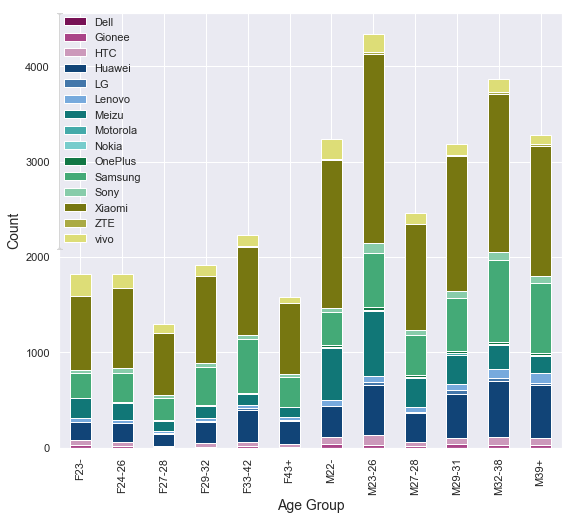

In [9]:
# Using the remaining data that we have,
group_df = merged_user_phone_df.groupby(
    ['group', 'brand']).agg('count')[['age']]
group_df = group_df.rename(columns={'age': 'count'})
flatui = ["#771155", "#AA4488", "#CC99BB", "#114477", "#4477AA",
          "#77AADD", "#117777", "#44AAAA", "#77CCCC", "#117744",
          "#44AA77", "#88CCAA", "#777711", "#AAAA44", "#DDDD77",
          "#774411", "#AA7744", "#DDAA77", "#771122", "#AA4455", "#DD7788"]
sns.set_palette(sns.color_palette(flatui))
ax = group_df.unstack().plot(kind='bar', stacked=True, figsize=(9, 8))
art = []
lgd = plt.legend(list(group_df.unstack(1).columns.get_level_values(1)),
                 bbox_to_anchor=(0, 1), borderaxespad=0., mode="expand")
art.append(lgd)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Age Group", fontsize=14)
plt.show()

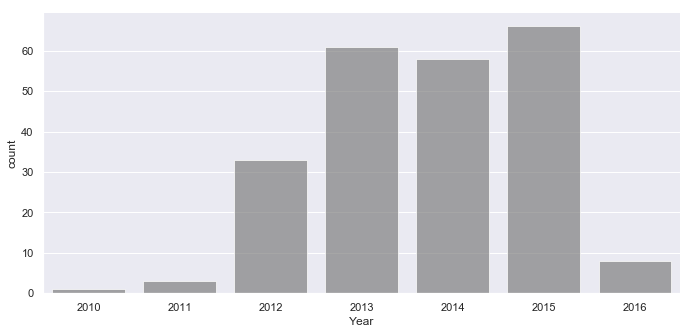

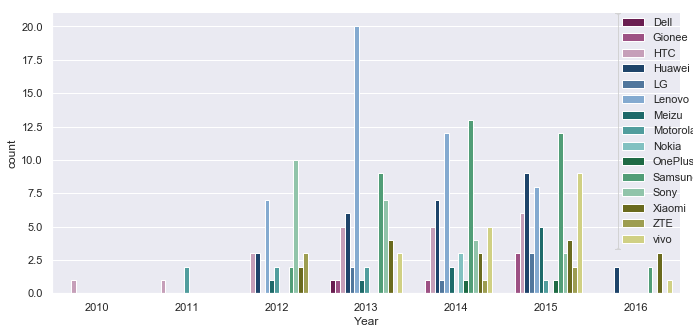

In [10]:
# Lets take a look at some release dates (for what we can parse)
def parse_release_date(row):
    '''This function will parse the announced row to find a release date, 
        if the release date is not found then we will set the value to the announcement date.'''
    split_r = str(row).split('.')
    if (len(split_r) > 1):
        # Use the release date if possible
        if(re.search('\d{4}', split_r[1])):
            return pd.to_datetime(re.search('\d{4}', split_r[1]).group(0), infer_datetime_format=True)
        else:
            return np.nan
    else:
        # If we couldn't find a release date use the announcement date
        if(re.search('\d{4}', split_r[0])):
            return pd.to_datetime(re.search('\d{4}', split_r[0]).group(0), infer_datetime_format=True)
        else:
            return np.nan


brand_df = merged_user_phone_df.groupby(
    ['brand', 'model']).agg('count')[['age']]
brand_df = brand_df.rename(columns={'age': 'count'})
phone_df['release_date'] = phone_df.announced.apply(parse_release_date)
new_brand_df = pd.merge(left=brand_df.reset_index([0, 1]), right=phone_df, left_on=['model', 'brand'],
                        right_on=['model', 'brand'], how='left')
data1 = new_brand_df.loc[:, [
    'brand', 'model', 'release_date', 'count']].dropna()
data1['Year'] = data1.release_date.dt.strftime('%Y').astype(int)

sns.catplot(x='Year', data=data1, kind='count',
            color='gray', alpha=.7, height=4.8, aspect=2)
sns.catplot(x='Year', data=data1, kind='count',
            hue='brand', legend=False, height=4.8, aspect=2)
plt.legend(data1.brand.unique(), bbox_to_anchor=(.9, 1),
           loc=1, borderaxespad=0., mode="expand")
plt.show()

-  This graph shows that the data was collected in 2016 and most of the users at that time had phones ranging between 1 to 3 years old. In addition, the second graph shows the Lenovo's flood in the market with new phones but we can see that none of the most popular phones belong to Lenovo. This brings a hypothesis that simply releasing new phone models does not generate sales.

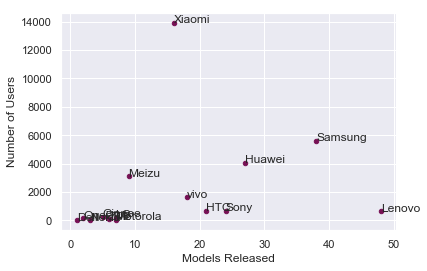

(0.25716924520989676, 0.35480924810874837)

In [11]:
# Do the number of models that a brand releases make a difference in brand popularity?
brand_pop_df = data1.groupby('brand').agg(np.sum)[["count"]].join(
    brand_df.reset_index().groupby('brand').agg('count')[["model"]])
brand_pop_df = brand_pop_df.reset_index()
variable = brand_pop_df.plot('model', 'count', kind='scatter')
for i in range(len(brand_pop_df.brand)):
    variable.annotate(
        brand_pop_df.brand[i], (brand_pop_df['model'][i], brand_pop_df['count'][i]))
plt.xlabel("Models Released")
plt.ylabel("Number of Users")
plt.show()
type(variable)
stats.pearsonr(brand_pop_df['model'], brand_pop_df['count'])

-  There is a small positive correlation between the number of models released and the number of users but the p-value is too high to be considered a valid conclusion. You can also see the outliers of the data. For example Xiaomi has only release ~16 models but has sold a ton of phones, whereas Lenovo released ~48 models but sold less than a thousand. 

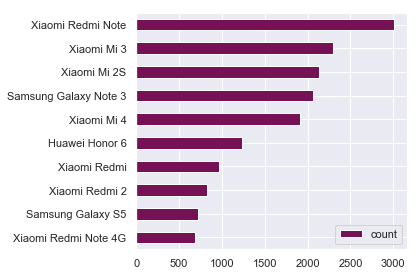

In [12]:
# This will fix labelling issues
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Plot the top 10 phone models of the dataset
top_10_models_df = new_brand_df.sort_values(
    'count', ascending=False).reset_index().loc[0:9, ['brand', 'model', 'count']][::-1]
top_10_models_df.plot(kind='barh')

plt.yticks(np.arange(10), top_10_models_df.brand+" "+top_10_models_df.model)
plt.show()
# This graph shows how dominate Xiaomi is in the market at the time this data was collected

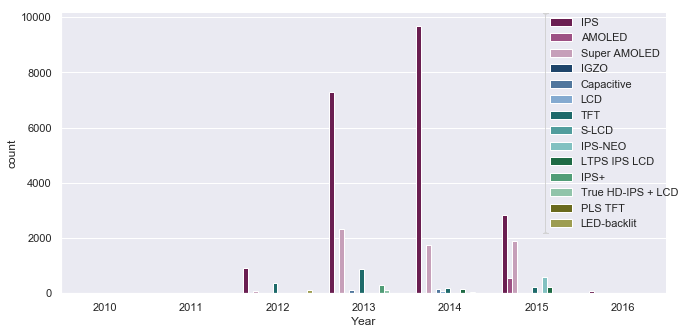

In [13]:
# Try to work with display type to see if the display technology has been shifted over the years
display_type_df = merged_user_phone_df

display_type_df['release_date'] = display_type_df.announced.apply(
    parse_release_date)
display_type_df["short_display_type"] = [item[0]
                                         for item in display_type_df.display_type.str.split()[0:]]
display_type_df["Year"] = display_type_df.release_date.dt.strftime(
    '%Y').astype(int, errors='ignore')
display_type_df = display_type_df[display_type_df.Year != "NaT"].reindex()
display_type_df = display_type_df.replace({"Super": "Super AMOLED", "True": "True HD-IPS + LCD", "LTPS": "LTPS IPS LCD",
                                           "PLS": "PLS TFT"})
sns.catplot(x='Year', data=display_type_df, kind='count',
            hue='short_display_type', legend=False, height=4.8, aspect=2)
plt.legend(display_type_df.short_display_type.unique(),
           bbox_to_anchor=(.8, 1), loc=1, borderaxespad=0., mode="expand")
plt.show()

In [14]:
year_display_df = display_type_df.groupby(
    ["Year", "short_display_type"]).agg('count')[["brand"]]
year_display_df.index.names = ["Year", "Display_Type"]
year_display_df.rename(columns={"brand": "Count"}, inplace=True)
display(year_display_df)

Count
Year Display_Type            
2010 LCD                    2
2011 Capacitive             8
     S-LCD                  9
     TFT                    8
2012 IPS                  913
     IPS+                   2
     LED-backlit          110
     PLS TFT                1
     Super AMOLED          71
     TFT                  382
2013 AMOLED                23
     Capacitive           126
     IGZO                   8
     IPS                 7309
     IPS+                 301
     Super AMOLED        2346
     TFT                  865
     True HD-IPS + LCD    123
2014 Capacitive           151
     IPS                 9665
     LCD                   76
     LTPS IPS LCD         138
     Super AMOLED        1737
     TFT                  177
     True HD-IPS + LCD     51
2015 AMOLED               551
     Capacitive             8
     IPS                 2820
     IPS-NEO              595
     LTPS IPS LCD         229
     Super AMOLED        1884
     TFT                  236
2016 IPS                   80
     IPS-NEO                1
     Super AMOLED          16

-  Sometimes a table is easier to see than a graph. The graph displays the explosive usage of IPS screens starting from 2013 and going into 2014. The graph also shows the introduction of AMOLED and Super AMOLED screens to the market.  
-  There is also some unidentified displays such as the ones labelled just as "Capactive" or "LED-backlit" because that isn't a type of display but a description of a display type as multiple display types can be capacitive or LED-backlit. 

In [15]:
merged_user_phone_df.head()

,brand,model,network_technology,2G_bands,3G_bands,4G_bands,network_speed,GPRS,EDGE,announced,...,device_id,phone_brand,device_model,gender,age,group,translated_brand,release_date,short_display_type,Year
0,Dell,Venue 7,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,HSDPA 900 / 2100,NaN,HSPA,Yes,Yes,2013 October. Released 2013 October,...,545684076500721609,戴尔,Venue 7,F,30.0,F29-32,Dell,2013-01-01,IPS,2013
1,Gionee,S6,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA,LTE,HSPA LTE Cat4 150/50 Mbps,Yes,Yes,2015 November,...,-1441674161052134138,金立,S6,M,21.0,M22-,Gionee,2015-01-01,AMOLED,2015
2,Gionee,S6,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA,LTE,HSPA LTE Cat4 150/50 Mbps,Yes,Yes,2015 November,...,-5151121249857726632,金立,S6,M,28.0,M27-28,Gionee,2015-01-01,AMOLED,2015
3,Gionee,S6,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA,LTE,HSPA LTE Cat4 150/50 Mbps,Yes,Yes,2015 November,...,-9206202041936929793,金立,S6,M,20.0,M22-,Gionee,2015-01-01,AMOLED,2015
4,Gionee,S6,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA,LTE,HSPA LTE Cat4 150/50 Mbps,Yes,Yes,2015 November,...,84531262382922370,金立,S6,M,25.0,M23-26,Gionee,2015-01-01,AMOLED,2015


In [16]:
events_merged_df = merged_user_phone_df.merge(dfdict['events.csv'].drop_duplicates('device_id'),on='device_id')
app_df = events_merged_df.merge(dfdict['app_events.csv'].drop_duplicates('event_id'),on='event_id')
data_df = app_df.merge(dfdict['app_labels.csv'].drop_duplicates('app_id'),on='app_id')

In [17]:
from sklearn.model_selection import train_test_split

gender_map = {'F': 0, 'M': 1}
X = data_df[['gender','age', 'Year', 'label_id']]
X['gender'] = X['gender'].map(gender_map)
X.Year = X['Year'].astype(int)
category_map = {'Gionee': 0,
                'HTC': 1,
                'Huawei': 2,
                'LG': 3,
                'Lenovo': 4,
                'Meizu': 5,
                'Motorola': 6,
                'Nokia': 7,
                'OnePlus': 8,
                'Samsung': 9,
                'Sony': 10,
                'Xiaomi': 11,
                'ZTE': 12,
                'vivo': 13}
y_cat = data_df['translated_brand'].astype('category')
y = data_df['translated_brand'].map(category_map)
inv_map = {v: k for k, v in category_map.items()}
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

new_training_df = pd.concat([X_train, y_train.map(inv_map)], axis='columns')
# This is the spread of our training data
display(new_training_df.groupby('translated_brand').agg('count')[['age']].rename(
    columns={'age': 'count'}).sort_values(by='count', ascending=False))

new_test_df = pd.concat([X_test, y_test.map(inv_map)], axis='columns')
# This is the spread of our training data
display(new_test_df.groupby('translated_brand').agg('count')[['age']].rename(
    columns={'age': 'count'}).sort_values(by='count', ascending=False))


,count
translated_brand,
Xiaomi,1974
Samsung,1073
Huawei,854
Meizu,633
vivo,272
Sony,85
HTC,68
Lenovo,63
Gionee,45


,count
translated_brand,
Xiaomi,835
Samsung,460
Huawei,411
Meizu,268
vivo,119
Gionee,23
HTC,23
Sony,20
Lenovo,15


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', random_state=42)
params = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"]}
gridsearch = GridSearchCV(logreg, params, cv=5)
gridsearch.fit(X_train, y_train)
labels = gridsearch.predict(X_test)

In [19]:
from sklearn.metrics import log_loss
pred = gridsearch.predict_proba(X_test)
log_loss(y_test,pred) 

2.4423408793555881

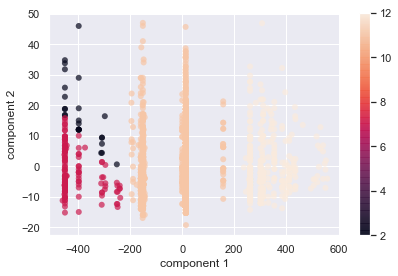

[('Huawei', 2), ('Xiaomi', 11), ('ZTE', 12), ('Nokia', 7)]

In [80]:
from sklearn.decomposition import PCA
# Graph the classification to get a better idea of how our classifier is working
pca = PCA(n_components=2)
projected = pca.fit_transform(X_test)
gridsearch.score(X_test, y_test)
plt.scatter(projected[:, 0], projected[:, 1],
            c=labels, edgecolor='none', alpha=0.7)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()
all_labels = [(inv_map[v],v) for v in set(labels)]
all_labels

-  This graph shows how logistic regression seems to fail classifying our data as a lot of the classes (even ones that had a lot of data like Samsung were lost in the fitting process)

In [82]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_ohc_train = onehot_encoder.fit_transform(y_train.reshape(-1,1))
y_ohc_test = onehot_encoder.fit_transform(y_test.reshape(-1,1))

In [113]:
import xgboost as xgb

xgbClf = xgb.XGBClassifier(objective='multi:softmax',n_estimators=400)
xgbClf.fit(X_train, y_train,eval_set=[(X_test, y_test)], eval_metric='mlogloss', early_stopping_rounds=15)

pred = xgbClf.predict_proba(X_test)
log_loss(y_test, pred)

[0]	validation_0-mlogloss:2.48346
Will train until validation_0-mlogloss hasn't improved in 15 rounds.
[1]	validation_0-mlogloss:2.36612
[2]	validation_0-mlogloss:2.27239
[3]	validation_0-mlogloss:2.19464
[4]	validation_0-mlogloss:2.12712
[5]	validation_0-mlogloss:2.06902
[6]	validation_0-mlogloss:2.01804
[7]	validation_0-mlogloss:1.97223
[8]	validation_0-mlogloss:1.93131
[9]	validation_0-mlogloss:1.89589
[10]	validation_0-mlogloss:1.86317
[11]	validation_0-mlogloss:1.83403
[12]	validation_0-mlogloss:1.80719
[13]	validation_0-mlogloss:1.78334
[14]	validation_0-mlogloss:1.76148
[15]	validation_0-mlogloss:1.74122
[16]	validation_0-mlogloss:1.72319
[17]	validation_0-mlogloss:1.7066
[18]	validation_0-mlogloss:1.69055
[19]	validation_0-mlogloss:1.67638
[20]	validation_0-mlogloss:1.6638
[21]	validation_0-mlogloss:1.65191
[22]	validation_0-mlogloss:1.64145
[23]	validation_0-mlogloss:1.63126
[24]	validation_0-mlogloss:1.62211
[25]	validation_0-mlogloss:1.61383
[26]	validation_0-mlogloss:1.6057

1.4842022586275998

In [103]:
xgbClf.score(X_test, y_test)

0.44444444444444442

In [116]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

n_classes = 14
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_ohc_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_ohc_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

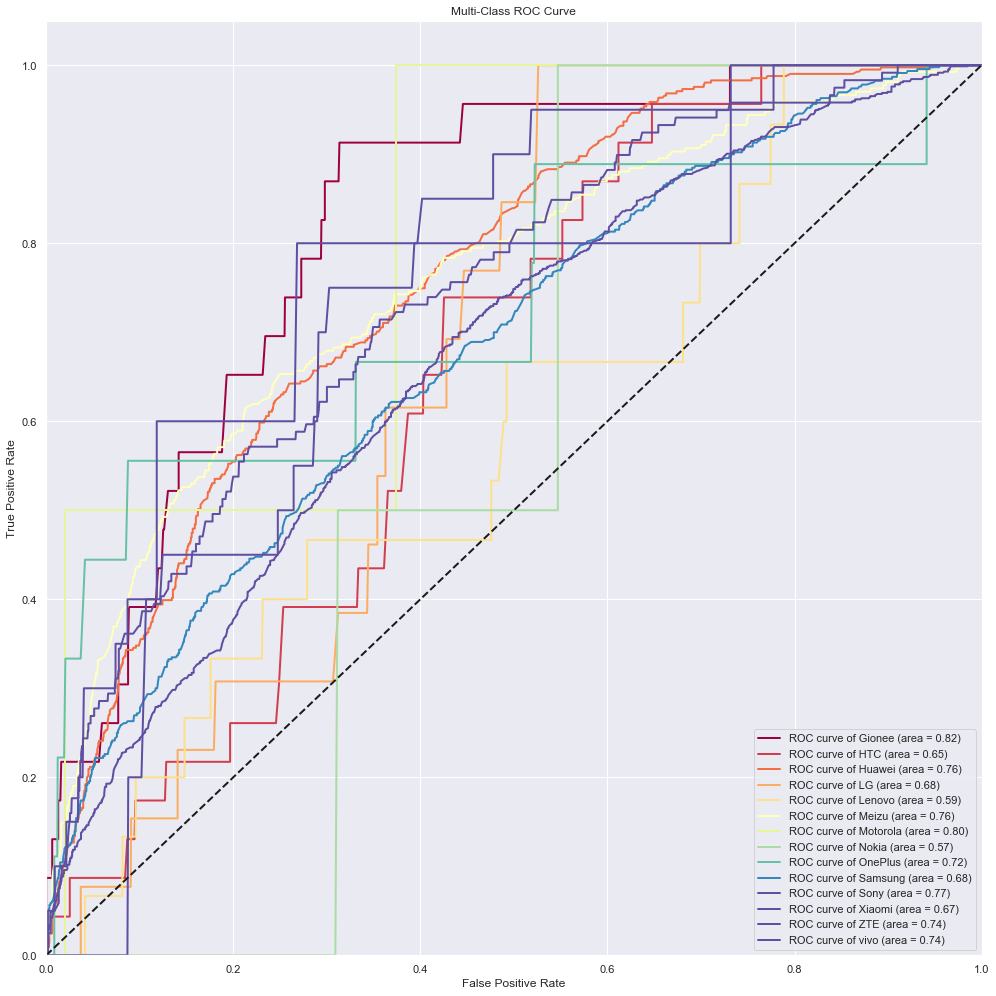

In [134]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(14)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(14,14))

colors = cycle([plt.cm.get_cmap('Spectral')(i/10.0) for i in range(15)])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of {inv_map[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()
